In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd

In [27]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# We can view all of the classes that automap found
print(Base.classes.keys())
print(Base.metadata.tables['measurement'].columns.keys())
print(Base.metadata.tables['station'].columns.keys())

['measurement', 'station']
['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-09-30 15:54:44.483140


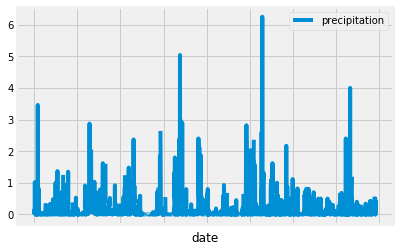

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
lastyear_date=dt.datetime.today()+relativedelta(years=-2)
print(lastyear_date)

# Perform a query to retrieve the data and precipitation scores
measurement_data=session.query(Measurement).filter(Measurement.date>=lastyear_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = [{'date':pt.date, 'precipitation': pt.prcp ,'station':pt.station, 'temperature':pt.tobs} for pt in measurement_data]
df=pd.DataFrame(df)

x_axis=df['date']
df=df.set_index('date')

# Sort the dataframe by date
df=df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
#plt.scatter(x_axis,df['precipitation'],marker='o',linewidths=1,label='precipitation')
df['precipitation'].plot()

# Rotate the xticks for the dates
plt.xticks()
plt.legend()
plt.show()

![precipitation](Images/precipitation.png)

In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation,temperature
count,1795.000000,1981.000000
mean,0.160485,74.182231
std,0.424741,4.648189
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.010000,75.000000
75%,0.120000,78.000000
max,6.250000,87.000000


In [36]:
# How many stations are available in this dataset?
session.query(Station).count()

9

In [37]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations=session.query(Station).group_by(Station.station).order_by(func.count(Station.station).desc()).all()

for station in active_stations:
    print(station.station, station.name) 

USC00511918 HONOLULU OBSERVATORY 702.2, HI US
USC00513117 KANEOHE 838.1, HI US
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US
USC00516128 MANOA LYON ARBO 785.2, HI US
USC00517948 PEARL CITY, HI US
USC00518838 UPPER WAHIAWA 874.3, HI US
USC00519281 WAIHEE 837.5, HI US
USC00519397 WAIKIKI 717.2, HI US
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US


In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station=active_stations[0].station
print(most_active_station)

q=session.query(func.min(Measurement.tobs).label('lowest T'),func.max(Measurement.tobs).label('highest T'),func.avg(Measurement.tobs).label('Average T'))\
                .filter(Measurement.station==most_active_station).group_by(Measurement.station).all()
print(q)


USC00511918
[(53.0, 87.0, 71.61596766043456)]


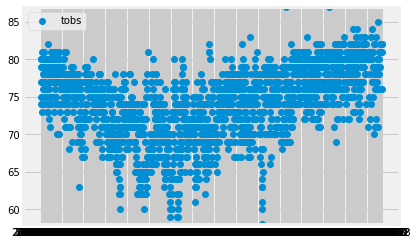

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
q=session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>=lastyear_date).all()
df=pd.DataFrame(q).sort_values(by='date')
#Plot Temperature
plt.scatter(x=df['date'],y=df['tobs'],linewidths=1)
plt.x_label='date'
plt.y_label='Temp'
plt.ylim(df['tobs'].min(),df['tobs'].max())
plt.legend()
plt.show()

In [40]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [41]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
q = calc_temps(lastyear_date,dt.datetime.today())
TMIN=q[0][0]
TAVG=q[0][1]
TMAX=q[0][2]
print(f'Min. Temp: {TMIN}, Avg. Temp{TAVG}, Max. Temp{TMAX}')

Min. Temp: 58.0, Avg. Temp74.18223119636548, Max. Temp87.0


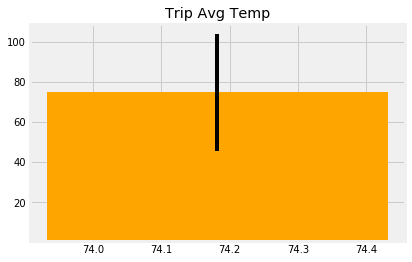

In [97]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(TAVG,height=TAVG,yerr=TMAX-TMIN, align='center',color='orange',bottom=0.5,width=0.5)
plt.title('Trip Avg Temp')
plt.show()

In [98]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,Measurement.prcp]
q=session.query(*sel).group_by(Station.station).filter(Station.station==Measurement.station).order_by(Measurement.prcp.desc())
q.all()

[('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  11.53),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  9.64),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.06),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 7.65),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  6.38),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 6.3),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 4.2),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  4.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.8)]

## Optional Challenge Assignment

In [99]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [100]:
# calculate the daily normals for your trip
normals=[]
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
startDate=dt.datetime.strptime('2017-01-01','%Y-%m-%d')
endDate =dt.datetime.strptime('2017-01-07','%Y-%m-%d')
days= (endDate - startDate).days
# Use the start and end date to create a range of dates
dates=[startDate + relativedelta(days=x) for x in range(days+1)]
#print(dt.datetime.strftime(dates[1],'%m-%d'))
# Stip off the year and save a list of %m-%d strings
dates = [dt.datetime.strftime(date,'%m-%d') for date in dates]
#print(dates)
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dates:
    normals.append(daily_normals(date)[0])

#normals=tuple(normals)
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame(normals,columns=['tmin', 'tavg','tmax'])
df['trip_dates']=pd.DataFrame(dates)
df=df.set_index('trip_dates')
df

,tmin,tavg,tmax
trip_dates,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


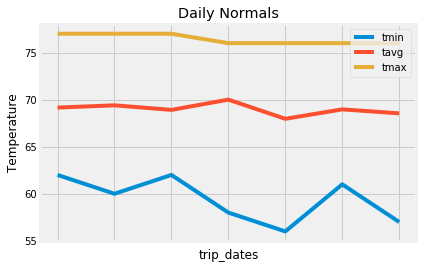

In [102]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(stacked=False)
plt.legend(loc='upper right')
plt.title('Daily Normals')
plt.ylabel('Temperature')
plt.show()

# # Step 2 - Climate App

Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

* Use FLASK to create your routes.

### Routes

In [108]:
from flask import Flask, jsonify
#Flask setup
app = Flask(__name__)

In [109]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return the precipitation data as json"""
    lastyear_date=dt.datetime.today()+relativedelta(years=-2)
    # Perform a query to retrieve the data and precipitation scores
    prcp_data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=lastyear_date)
    return jsonify(prcp_data)

In [110]:
if __name__ == "__main__":
    app.run(debug=True)

UnsupportedOperation: not writable